<a href="https://colab.research.google.com/github/lucienrivat/PommePOire/blob/main/PommePoir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

10038260/10038260 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16550943/16550943 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 4711 files belonging to 2 classes.
Using 3769 files for training.
Found 4711 files belonging to 2 classes.
Using 942 files for validation.


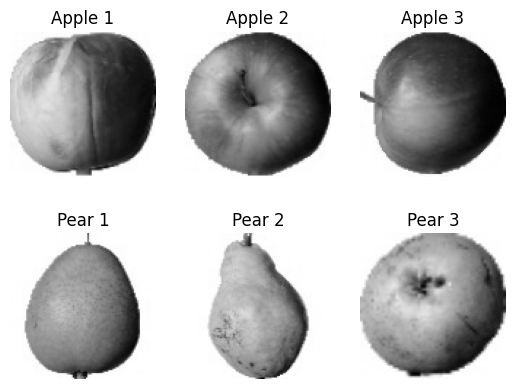

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import pathlib
import os
import zipfile
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import files

# Fonction pour convertir toutes les images en niveaux de gris
def convert_to_grayscale(input_folder):
    for img_path in pathlib.Path(input_folder).rglob("*.*"):
        img = cv2.imread(str(img_path))
        if img is not None:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(str(img_path), gray_img)

# Télécharger et extraire les fichiers ZIP Apple et Pear
apple_zip = tf.keras.utils.get_file("Apple.zip", "https://github.com/lucienrivat/PommePOire/raw/main/apple.zip", extract=False)
pear_zip = tf.keras.utils.get_file("Pear.zip", "https://github.com/lucienrivat/PommePOire/raw/main/pear.zip", extract=False)

with zipfile.ZipFile(apple_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets/')
with zipfile.ZipFile(pear_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets/')

# Définir les chemins
apple_data_dir = pathlib.Path('/content/datasets/apple')
pear_data_dir = pathlib.Path('/content/datasets/pear')

# Convertir toutes les images en niveaux de gris
convert_to_grayscale(apple_data_dir)
convert_to_grayscale(pear_data_dir)

# Paramètres
data_dir = pathlib.Path('/content/datasets/')
batch_size = 3
img_height = 200
img_width = 200

# Charger le dataset avec un traitement en niveaux de gris
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="training", seed=42,
    image_size=(img_height, img_width), batch_size=batch_size, color_mode='grayscale'
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="validation", seed=42,
    image_size=(img_height, img_width), batch_size=batch_size, color_mode='grayscale'
)

import collections

train_labels = []
for images, labels in train_data:
    train_labels.extend(labels.numpy())
images_to_display = []

# Sélectionner 3 images aléatoires d'Apple
for _ in range(3):
    apple_image = random.choice(list(apple_data_dir.glob('*/*.jpg')))
    img_apple = mpimg.imread(apple_image)
    images_to_display.append(img_apple)

# Sélectionner 3 images aléatoires de Pear (à partir de sous-dossiers)
pear_subfolders = [folder for folder in os.listdir(pear_data_dir) if os.path.isdir(os.path.join(pear_data_dir, folder))]

for _ in range(3):
    chosen_pear_folder = random.choice(pear_subfolders)
    pear_images = list(pathlib.Path(pear_data_dir, chosen_pear_folder).glob('*.*'))
    random_pear_image = random.choice(pear_images)
    img_pear = mpimg.imread(random_pear_image)
    images_to_display.append(img_pear)

# Afficher les images sélectionnées
for i, img in enumerate(images_to_display):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    if i < 3:
        plt.title(f"Apple {i + 1}")
    else:
        plt.title(f"Pear {i - 2}")
plt.show()

In [11]:
# Définition du modèle CNN adapté aux images en niveaux de gris
num_classes = 2
model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Entraînement
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs", histogram_freq=1, write_images=True)

class_weights = {0: len(train_labels) / 942, 1: len(train_labels) / 3769}

history = model.fit(train_data, validation_data=val_data, epochs=15, callbacks=[tensorboard_callback])


Epoch 1/15
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9213 - loss: 0.2254 - val_accuracy: 0.9873 - val_loss: 0.0918
Epoch 2/15
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9729 - loss: 0.1154 - val_accuracy: 0.9904 - val_loss: 0.0728
Epoch 3/15
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9883 - loss: 0.0514 - val_accuracy: 0.9904 - val_loss: 0.0652
Epoch 4/15
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9887 - loss: 0.0525 - val_accuracy: 0.9904 - val_loss: 0.0829
Epoch 5/15
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9913 - loss: 0.0369 - val_accuracy: 0.9915 - val_loss: 0.0581
Epoch 6/15
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9932 - loss: 0.0227 - val_accuracy: 0.9947 - val_loss: 0.0460
Epoch 7/15
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9983 - loss: 0.0049 - val_accuracy: 0.9958 - val_loss: 0.0366
Epoch 8/15
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 1.0000 - loss: 4.8242e-

In [12]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 200, 200, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 198, 198, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 99, 99, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 97, 97, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 46, 46, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 21, 21, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,621,352 (6.18 MB)

 Trainable params: 540,450 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,080,902 (4.12 MB)

Saving shutterstock_102978833.jpg to shutterstock_102978833 (6).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


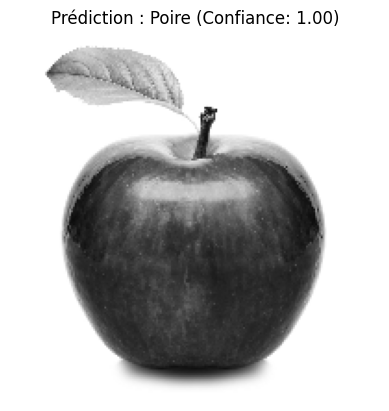

Prédiction : [Poire, Pomme] [[0.00198472 0.9980153 ]]
🍐 C'est une pomme !


In [22]:
def predict_image(image_path, model, threshold=0.6):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Erreur : Impossible de charger l'image {image_path}.")
        return None

    image = cv2.resize(image, (200, 200))
    image = np.expand_dims(image, axis=-1)  # Ajouter un canal
    image = np.expand_dims(image, axis=0)  # Ajouter la dimension batch

    predictions = model.predict(image)
    confidence = np.max(predictions)
    predicted_class = np.argmax(predictions)

    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f"Prédiction : {['Pomme', 'Poire'][predicted_class]} (Confiance: {confidence:.2f})")
    plt.show()
    print(f"Prédiction : [Poire, Pomme]",predictions)
    if confidence < threshold:
        print("🤔 Je ne suis pas sûr de cette classification.")
    elif predicted_class == 0:
        print("🍏 C'est une poire !")
    else:
        print("🍐 C'est une pomme !")

def process_uploaded_files(model):
    uploaded_files = files.upload()
    for file_name in uploaded_files.keys():
        image_path = os.path.join('/content', file_name)  # Correction du chemin
        predict_image(image_path, model)

process_uploaded_files(model)